# Data Exploration

1. [Introduction](#Introduction)
2. [Data Preparation](#Data-Preparation)
    1. [Download HDF5 Files](#Download-HDF5-Files)
    2. [Upload JPEG Files to S3](#Upload-JPEG-Files-to-S3)
    3. [Generate Augmented Manifest Files](#Generate-Augmented-Manifest-Files)
3. [Data Exploration](#Data-Exploration)
4. [Conclusion](#Conclusion)

## 1. Introduction

In this notebook we will load the HDF5 data from S3 and explore the data. We will also store JPEG files in S3 and create augmented manifest files to prepare for training our Image Classification model.

First, we need to set up the linkage and authentication to AWS services. There are two parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for storing images

In [1]:
!pip install h5pyd

In [1]:
%%time
import h5py
import io
import numpy as np
import pickle
import s3fs
import boto3
import re
import sagemaker
from sagemaker import get_execution_role

s3 = s3fs.S3FileSystem()

role = get_execution_role()

bucket = sagemaker.Session().default_bucket() #'sagemaker-us-east-1-513033806411'

CPU times: user 1.55 s, sys: 265 ms, total: 1.81 s
Wall time: 10.7 s


## 2. Data Preparation
### a) Download HDF5 files
Our data is stored in S3 as HDF5 files. The first thing we need to do is download them and convert them to a format we can use for training.

In [6]:
# Folder path
folder = 'lymph-node-image-classification/'

# File locations
train_X_key = folder + 'train_X/camelyonpatch_level_2_split_train_x.h5'
train_y_key = folder + 'train_y/camelyonpatch_level_2_split_train_y.h5'
valid_X_key = folder + 'valid_X/camelyonpatch_level_2_split_valid_x.h5'
valid_y_key = folder + 'valid_y/camelyonpatch_level_2_split_valid_y.h5'
test_X_key = folder + 'test_X/camelyonpatch_level_2_split_test_x.h5'
test_y_key = folder + 'test_y/camelyonpatch_level_2_split_test_y.h5'

train_X_loc = 's3://{}/{}'.format(bucket, train_X_key)
train_y_loc = 's3://{}/{}'.format(bucket, train_y_key)
valid_X_loc = 's3://{}/{}'.format(bucket, valid_X_key)
valid_y_loc = 's3://{}/{}'.format(bucket, valid_y_key)
test_X_loc = 's3://{}/{}'.format(bucket, test_X_key)
test_y_loc = 's3://{}/{}'.format(bucket, test_y_key)

In [19]:
def load_h5_data(file_loc, val):
    """Read h5 datasets to numpy arrays"""
    with s3.open(file_loc, "rb") as s3file:
        with h5py.File(s3file, "r") as f:
            out_array = f[val][()]
    return out_array

# Load training, validation, test as numpy arrays from hdf5 format
train_X = load_h5_data(train_X_loc, 'x')
train_y = load_h5_data(train_y_loc, 'y')
valid_X = load_h5_data(valid_X_loc, 'x')
valid_y = load_h5_data(valid_y_loc, 'y')
test_X = load_h5_data(test_X_loc, 'x')
test_y = load_h5_data(test_y_loc, 'y')

Save data to pickle files for easier loading in the future

In [4]:
def saveArrayToS3(npyArray, name):
    """Dump array to pickle file in S3"""
    with s3.open('{}/{}'.format(bucket, name), 'wb') as f: 
        f.write(pickle.dumps(npyArray, protocol=4)) # use protocol = 4 to overcome 4GB limitation for serialization
        
def readArrayFromS3(name):
    """Load pickle file as np array from S3"""
    return np.load(s3.open('{}/{}'.format(bucket, name)), allow_pickle=True)

In [32]:
# write pickle files
saveArrayToS3(train_X, folder + 'train_X/camelyonpatch_level_2_split_train_X.pkl')
saveArrayToS3(train_y, folder + 'train_y/camelyonpatch_level_2_split_train_y.pkl')
saveArrayToS3(valid_X, folder + 'valid_X/camelyonpatch_level_2_split_valid_X.pkl')
saveArrayToS3(valid_y, folder + 'valid_y/camelyonpatch_level_2_split_valid_y.pkl')
saveArrayToS3(test_X, folder + 'test_X/camelyonpatch_level_2_split_test_X.pkl')
saveArrayToS3(test_y, folder + 'test_y/camelyonpatch_level_2_split_test_y.pkl')

Now that our data is stored in pickle files, we can skip some of the above steps next time and start off below by loading the pickle files from S3

In [5]:
# load pickled arrays from s3
train_X = readArrayFromS3(folder + 'train_X/camelyonpatch_level_2_split_train_X.pkl')
train_y = readArrayFromS3(folder + 'train_y/camelyonpatch_level_2_split_train_y.pkl')
valid_X = readArrayFromS3(folder + 'valid_X/camelyonpatch_level_2_split_valid_X.pkl')
valid_y = readArrayFromS3(folder + 'valid_y/camelyonpatch_level_2_split_valid_y.pkl')
test_X = readArrayFromS3(folder + 'test_X/camelyonpatch_level_2_split_test_X.pkl')
test_y = readArrayFromS3(folder + 'test_y/camelyonpatch_level_2_split_test_y.pkl')

In [14]:
# Check shapes of each dataset
print(f"Training size: {train_X.shape}")
print(f"Validation size: {valid_X.shape}")
print(f"Test size: {test_X.shape}")

Training size: (262144, 96, 96, 3)
Validation size: (32768, 96, 96, 3)
Test size: (32768, 96, 96, 3)


### b) Upload JPEG files to S3
Our training requires JPEG files, so we will create those and store them in S3 using the code below.

In [11]:
from PIL import Image as im

s3 = boto3.client("s3")
folder = 'lymph-node-image-classification/'

def upload_images(im_arr, dataset, grayscale=False):
    """Upload all images as jpeg files"""
    if grayscale is True:
        color = 'grayscale'
    else:
        color = 'color'
    for i in range(im_arr.shape[0]):
        img_file = im.fromarray(im_arr[i])
        
        if color == 'grayscale':
            img_file = img_file.convert("L") 
        else:
            img_file = img_file.convert("RGB")

        in_mem_file = io.BytesIO()
        img_file.save(in_mem_file, format="png")
        in_mem_file.seek(0)
        file_name = folder + 'images/' + color + '/' + dataset + '/' + dataset + '_' + str(i) + '.jpg'

        # save image to local notebook
        #img_file.save(file_name) # only needed for creation of recordIO files
        
        # Upload image to s3
        s3.upload_fileobj(in_mem_file, bucket, file_name)

In [12]:
# Upload all images
upload_images(train_X, 'train', grayscale=False)
upload_images(valid_X, 'validation', grayscale=False)
upload_images(test_X, 'test', grayscale=False)

### c) Generate Augmented Manifest files
In order to accelerate the training process by taking full advantage of Pipe mode, we must create Augmented Manifest files. This is a json file with the following format for each record: 
`{'image-ref': 's3://sagemaker-us-east-1-513033806411/lymph-node-image-classification/images/color/train/train_0.jpg', 'class': 1}`

In [23]:
import json

def generate_manifest(data, set_name):
    """Create augmented manifest file"""
    with open('augmented_manifest_'+ set_name + '.json', 'w') as f:
        # write path for image and class
        for i, cl in zip(range(data.shape[0]), data.flatten()):
            path = folder + 'images/color/' + set_name + '/' + set_name + '_' + str(i) + '.jpg'
            meta = {"image-ref": "s3://{}/{}".format(bucket, path), "class": int(cl)}
            json.dump(meta, f) 
            f.write('\n')

# Generate manifest files
generate_manifest(train_y, 'train')
generate_manifest(valid_y, 'validation')

In [24]:
def upload_to_s3(channel, file):
    """Write file to S3"""
    s3 = boto3.resource("s3")
    data = open(file, "rb")
    key = channel + "/" + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

# Upload manifest files to S3
upload_to_s3(folder + 'train', 'augmented_manifest_train.json')
upload_to_s3(folder + 'validation', 'augmented_manifest_validation.json')

## 3. Data Exploration
Load and display the first 16 images

In [2]:
import cv2
import matplotlib.pyplot as plt

s3_client = boto3.client("s3")

# Load images
for i in range(16):
    file_name = 'train_'+str(i)+'.jpg'
    object_name = 'lymph-node-image-classification/images/color/train/train_'+str(i)+'.jpg'
    s3_client.download_file(bucket, object_name, file_name)
    
# Load labels    
train_y = readArrayFromS3(folder + 'train_y/camelyonpatch_level_2_split_train_y.pkl').flatten()

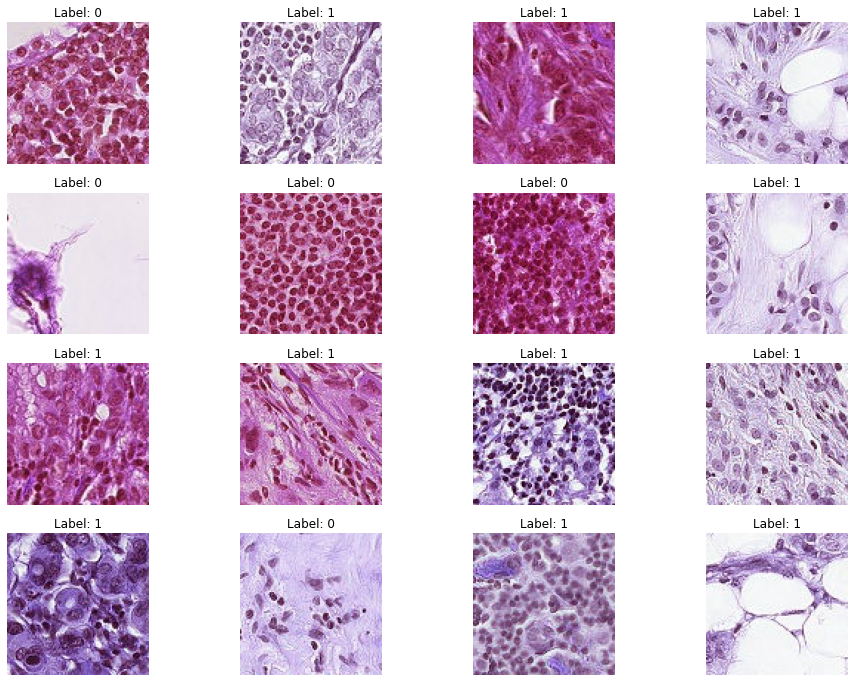

In [8]:
fig = plt.figure(figsize=(16, 12))
rows = 4
cols = 4
for i in range(16):
    # add subplot
    fig.add_subplot(rows, cols, i+1)
    
    # show image
    plt.imshow(cv2.imread('train_'+str(i)+'.jpg'))
    plt.axis('off')
    plt.title(f"Label: {train_y[i]}")

## 4. Conclusion
As we observe in the first 16 training images below, you need a highly trained set of eyes to identify metastases in these images. It is going to be challenging to predict these, but a convolutional neural network should be up for the task of detecting abnormal patterns in the cells that indicate metastasis.

Now that all of our data looks good and is stored in the proper formats, let's start building our model in the next notebook!